**Explore differentially expressed genes**  
This part will asssume that you have a list of differentially expressed genes already generated.  
Lets start with reading in some data to our session

In [1]:
suppressMessages(library(DESeq2)) # load the DESeq2 package

In [2]:
counts <- read.delim("data/counts.txt", sep="\t", check.names=FALSE, as.is=TRUE)

In [3]:
sample.info <- read.delim("data/sample_info.txt", sep="\t", check.names=FALSE)

In [4]:
model <- read.delim("data//diffexpr-results.csv", sep="\t", check.names=FALSE)

In [5]:
head(model)

,gene_name,gene_biotype,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000091972,CD200,protein_coding,308.88085,3.655514,0.2549227,14.24852,4.578529e-46,8.232652e-42
ENSG00000187601,MAGEH1,protein_coding,502.70770,3.161066,0.2713160,11.62730,2.994322e-31,2.692045e-27
ENSG00000235304,LINC01281,lincRNA,82.04318,4.885393,0.3725763,11.40383,4.001298e-30,2.398245e-26
ENSG00000125538,IL1B,protein_coding,1089.90272,-1.868674,0.1713032,-10.90638,1.074530e-27,4.830280e-24
ENSG00000003147,ICA1,protein_coding,449.93853,3.382331,0.3211397,10.50644,8.068215e-26,2.901491e-22
ENSG00000149257,SERPINH1,protein_coding,1233.86635,3.537105,0.3401214,10.40155,2.439450e-25,7.310624e-22


Subset data to significant genes and variance transform data (rlog)

In [86]:
#?rlog

In [7]:
counts <- counts[rownames(model),]

In [8]:
de <- DESeqDataSetFromMatrix(as.matrix(round(counts)), colData = sample.info, design=~Sample_Group)

converting counts to integer mode
it appears that the last variable in the design formula, 'Sample_Group',
  has a factor level, 'Control', which is not the reference level. we recommend
  to use factor(...,levels=...) or relevel() to set this as the reference level
  before proceeding. for more information, please see the 'Note on factor levels'
  in vignette('DESeq2').


In [9]:
dat <- rlog(de, blind=FALSE)

In [10]:
head(dat)

class: DESeqTransform 
dim: 6 10 
metadata(1): version
assays(1): ''
rownames(6): ENSG00000091972 ENSG00000187601 ... ENSG00000003147
  ENSG00000149257
rowData names(6): baseMean baseVar ... dispFit rlogIntercept
colnames(10): 6a 8a ... B5 B6
colData names(6): Sample_Biosource Concentration ... Sample_Group
  sizeFactor

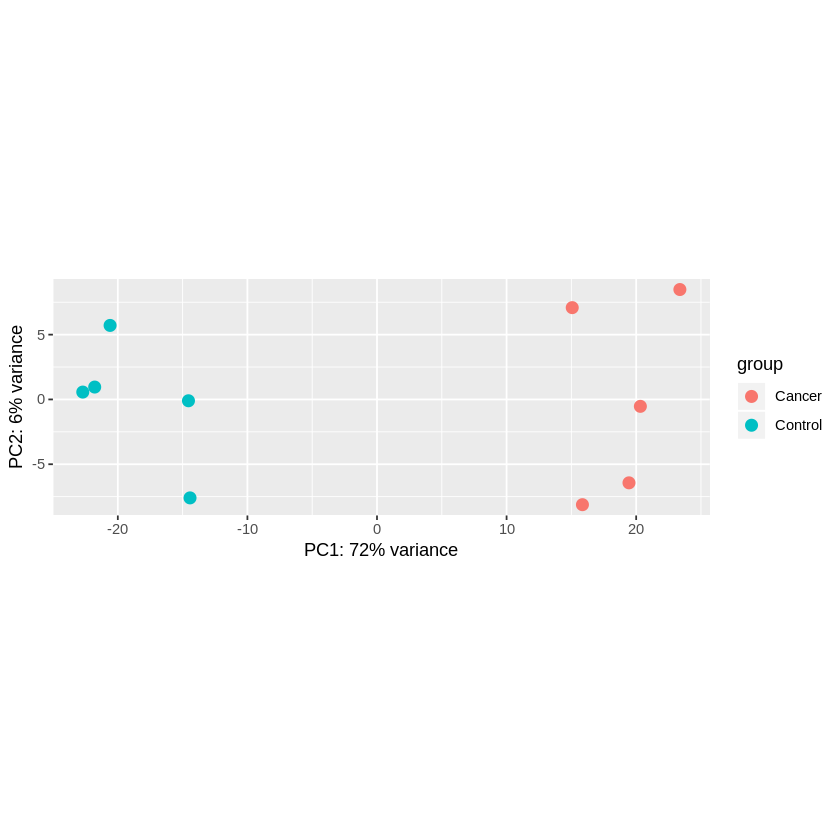

In [11]:
plotPCA(dat, intgroup="Sample_Group")

**Subclustering and Enrichment Analysis**  
Gene set enrichment is a method to identify classes of genes or proteins that are over-represented in a large set of genes or proteins, and may have an association with disease phenotypes. You can do enrichment analysis of all significant genes or a subset of significant genes. In this example we are going to cluster the genes using a network clustering approach and then look for functional origins of each cluster. Other common subsetting aprroaches are:  
1. p-value and fold change (from earlier analysis) 
2. Fold change sign (up and down regulated)
3. Genes that are extremes along a Principal Component (PCA)
4. Subclusters of gene that have a higher correlation among themselves compared to other genes (our choice)

In [26]:
suppressMessages(library(WGCNA))

For clustering we are going to use Weighted correlation network analysis, https://en.wikipedia.org/wiki/Weighted_correlation_network_analysis as implemented in the WGCNA package. https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/

In [75]:
net = blockwiseModules(t(assay(dat)),power=7,networkType="unsigned", mergeCutHeight = 0.1)


In [76]:
moduleColorsAutomatic = labels2colors(net$colors)
mColors = moduleColorsAutomatic[net$blockGenes[[1]]]


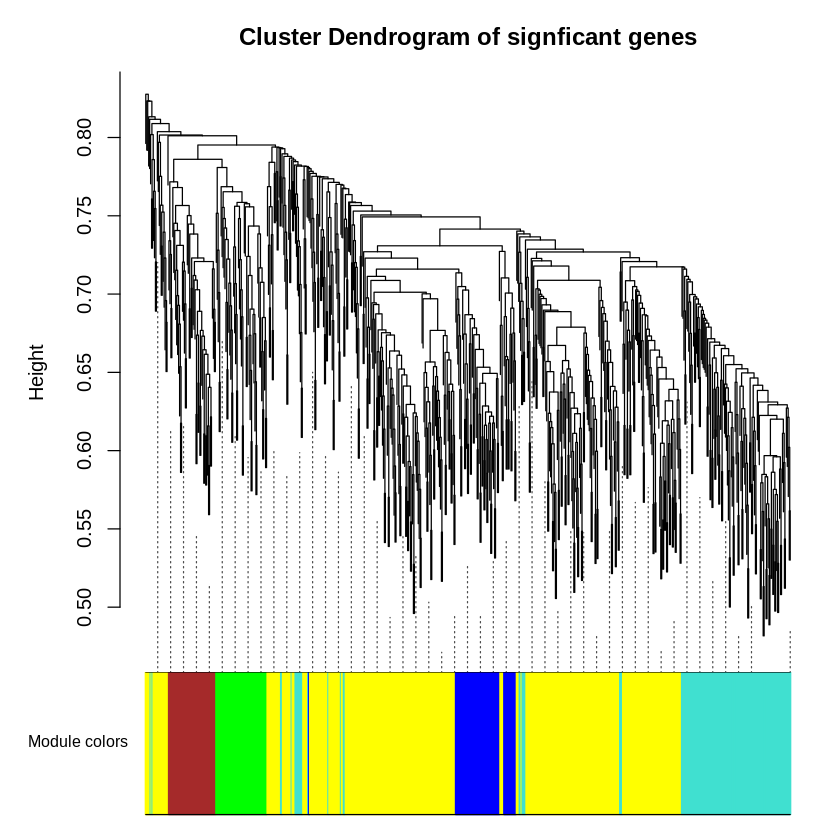

In [77]:
plotDendroAndColors(net$dendrograms[[1]], colors=mColors, dendroLabels=FALSE, 
                    groupLabels=c("Module colors"), addGuide=TRUE,
                    main="Cluster Dendrogram of signficant genes")

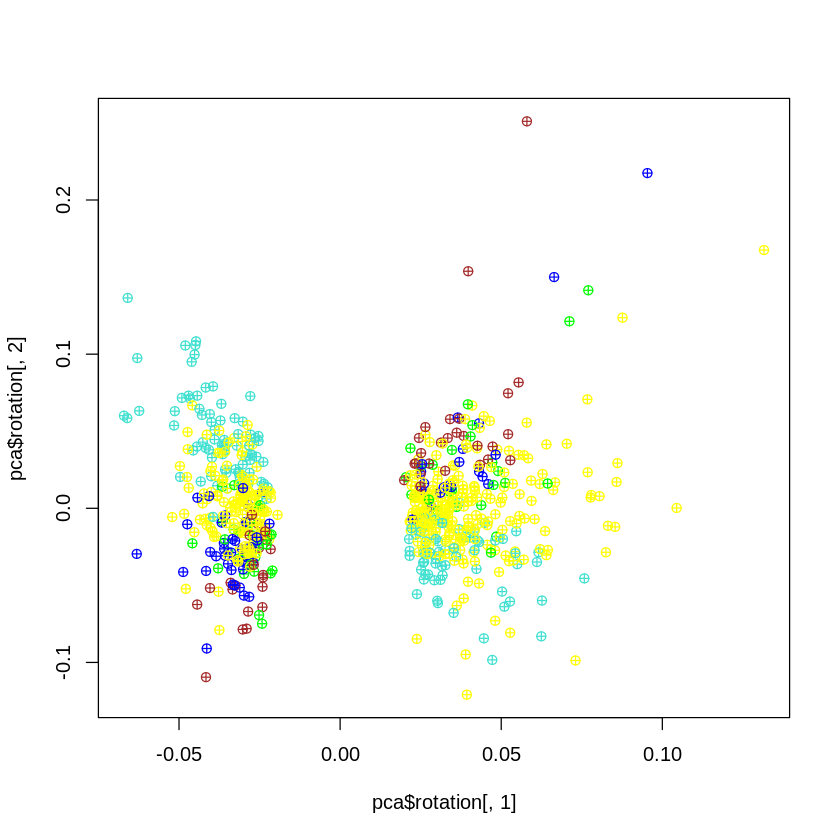

In [85]:
pca <- prcomp(datExpr)
plot(pca$rotation[,1], pca$rotation[,2], pch=10, col=mColors)

Now lets write the gene symbols for each cluster to a text file.

In [82]:
module_colors= setdiff(unique(mColors), "grey")
for (color in module_colors){
    module=model[which(mColors==color), "gene_name"]
    write.table(module, paste("module_",color, ".txt",sep=""), sep="\t", row.names=FALSE, col.names=FALSE,quote=FALSE)
}

Here is an example of fetching out up/down regulated genes:

In [92]:
up <- subset(model, log2FoldChange>0)[,"gene_name"]
down <- subset(model, log2FoldChange<0)[,"gene_name"]
write.table(up,"up.txt", sep="\t", row.names=FALSE, col.names=FALSE,quote=FALSE)
write.table(up,"down.txt", sep="\t", row.names=FALSE, col.names=FALSE,quote=FALSE)

**Your assignment:**  
There are several parameters to adjust. `P-value, fold change, power,networkType, mergeCutHeight` . Play around and look at the results.  
Upload these files to ENRICHR (http://amp.pharm.mssm.edu/Enrichr/enrich) and try to see if you can identify some underlying biology.  
Write up a short presentation (~5-10 min) of something intersting you found (interesting or maybe something you reckognize) that you can present for the rest of the class on Moday